In [1]:
import torch
from astra.torch.models import ResNetClassifier,ResNet18_Weights
from astra.torch.data import load_cifar_10
import torch
import torch.nn as nn
from glob import glob
from os.path import expanduser, join, basename, dirname
import xarray as xr
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from torch.utils.data import TensorDataset, DataLoader
from astra.torch.models import ResNetClassifier,ResNet18_Weights
from astra.torch.utils import train_fn

import torchvision.models as models
from astra.torch.metrics import accuracy_score, f1_score, precision_score, recall_score,classification_report

/home/rishabh.mondal/ASTRA/astra/torch/data.py:12: UserWarning: TORCH_HOME not set, setting it to /home/rishabh.mondal/.cache/torch
  warnings.warn(f"TORCH_HOME not set, setting it to {os.environ['TORCH_HOME']}")


In [2]:
dataset = load_cifar_10()


Files already downloaded and verified
Files already downloaded and verified


In [3]:
dataset


CIFAR-10 Dataset
length of dataset: 60000
shape of images: torch.Size([3, 32, 32])
len of classes: 10
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dtype of images: torch.float32
dtype of labels: torch.int64
range of image values: min=0.0, max=1.0
            

In [12]:
n_train=1000
n_test=20000
y=dataset.targets
x=dataset.data
classes=dataset.classes
class_1_idx=classes.index('frog')
class_1_mask=y==class_1_idx
y=class_1_mask.byte()
print(y)

tensor([1, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8)


In [14]:
print(len(y))
idx=torch.randperm(len(y))
train_data=x[idx[:n_train]]
train_targets=y[idx[:n_train]]
test_data=x[idx[-n_test:]]
test_targets=y[idx[-n_test:]]
pool_data=x[idx[n_train:-n_test]]
pool_targets=y[idx[n_train:-n_test]]
print(pool_data.shape)
print(train_data.shape)
print(train_targets.shape)
print(test_data.shape)
print(test_targets.shape)
print(pool_targets.shape)



60000
torch.Size([39000, 3, 32, 32])
torch.Size([1000, 3, 32, 32])
torch.Size([1000])
torch.Size([20000, 3, 32, 32])
torch.Size([20000])
torch.Size([39000])


: 

In [6]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset=TensorDataset(train_data,train_targets)
test_dataset=TensorDataset(test_data,test_targets)
pool_dataset=TensorDataset(pool_data,pool_targets)
train_loader=DataLoader(train_dataset,batch_size=254,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=254,shuffle=False)
pool_loader=DataLoader(pool_dataset,batch_size=254,shuffle=True)

In [7]:
import torchvision.models as models
import torch.nn as nn

train_model = ResNetClassifier(
    models.resnet18,None, n_classes=2, activation=nn.GELU(), dropout=0.1
).to("cuda")

In [8]:
iter_losses, epoch_losses = train_fn(
    train_model,
    nn.CrossEntropyLoss(),
    dataloader=train_loader,
    lr=3e-4,
    epochs=100,
    verbose=True,
)

  0%|          | 0/100 [00:00<?, ?it/s]

Loss: 0.00001184: 100%|██████████| 100/100 [00:07<00:00, 13.86it/s]


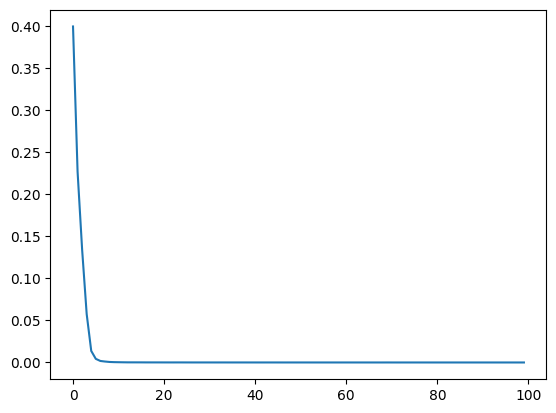

In [9]:
plt.plot(epoch_losses)

In [10]:
with torch.no_grad():
    pred_classes =train_model.predict_class(
        dataloader=test_loader, batch_size=254, verbose=True
    ).to("cuda")

test_labels = test_targets.to("cuda")
print("Accuracy: ", accuracy_score(pred_classes,test_labels))
print("Precision: ", precision_score(pred_classes,test_labels))
print("Recall: ", recall_score(pred_classes,test_labels))
print("F1: ", f1_score(pred_classes,test_labels))
print("classification report: ", classification_report(pred_classes,test_labels))

100%|██████████| 79/79 [00:00<00:00, 202.70it/s]


Accuracy:  tensor(0.8783, device='cuda:0')
Precision:  tensor(0.4117, device='cuda:0')
Recall:  tensor(0.4416, device='cuda:0')
F1:  tensor(0.4261, device='cuda:0')
classification report:  {'accuracy': tensor(0.8783, device='cuda:0'), 'precision': tensor(0.4117, device='cuda:0'), 'recall': tensor(0.4416, device='cuda:0'), 'f1': tensor(0.4261, device='cuda:0')}


### SSL Part